In [1]:
%autosave 0
import numpy as np 
import pandas as pd 
from pandas import read_csv, DataFrame
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import Pipeline

import keras
from keras.models import Sequential
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Activation
from keras import metrics
from keras import optimizers
from keras import regularizers

from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt

# ignore Warning
import warnings
warnings.filterwarnings("ignore") 



Autosave disabled


Using TensorFlow backend.


In [2]:
#### Mettre la variable sur True si recherche des paramétres opti, mais l'opération dure environ 45 minutes
lookForOptimiz = True

In [3]:
df_train = read_csv('new_Basetrain.csv')
df_Kagg = read_csv('new_kaggtest.csv')

submission = pd.DataFrame()
submission["Id"]= df_Kagg["Id"]

# Preparation du split

In [4]:
X_train = df_train

V_train = df_train['target'].values
F_train = df_train.drop(['target','SalePriceLog'], axis=1)

F_train

,Id,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,T_garage,T_Overall
0,1,856,854,0,1,3,0,4,3,706.0,...,8,856.0,856,0,2003,2003,2,2566.0,14.0,11
1,2,1262,0,0,1,3,0,4,1,978.0,...,6,1262.0,1262,298,1976,1976,1,2524.0,14.0,13
2,3,920,866,0,1,3,0,4,2,486.0,...,6,920.0,920,0,2001,2002,2,2706.0,14.0,11
3,4,961,756,0,1,3,0,1,3,216.0,...,7,756.0,961,0,1915,1970,0,2473.0,16.0,11
4,5,1145,1053,0,1,4,0,4,0,655.0,...,9,1145.0,1145,192,2000,2000,2,3343.0,15.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,953,694,0,1,3,0,4,3,0.0,...,7,953.0,953,0,1999,2000,1,2600.0,14.0,10
1449,1457,2073,0,0,1,3,0,4,3,790.0,...,7,1542.0,2073,349,1978,1988,4,3615.0,15.0,11
1450,1458,1188,1152,0,1,4,0,1,3,275.0,...,9,1152.0,1188,0,1941,2006,4,3492.0,13.0,15
1451,1459,1078,0,0,1,2,0,4,2,49.0,...,5,1078.0,1078,366,1950,1996,4,2156.0,14.0,10


In [5]:
V_train

array([208500., 181500., 223500., ..., 266500., 142125., 147500.])

In [6]:
seed = 42
np.random.seed(seed)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(F_train, V_train, test_size=0.3, random_state=seed)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)
df_Kagg = scale.transform(df_Kagg)

y_scale = StandardScaler()
y_scale.fit(y_train.reshape(-1, 1))
y_train = y_scale.transform(y_train.reshape(-1, 1))
y_val_resc = y_scale.transform(y_val.reshape(-1, 1))

df_Kagg

array([[ 1.71548419, -0.73817939, -0.79127308, ..., -1.04410074,
        -0.06083723, -0.41119226],
       [ 1.71783886,  0.44538301, -0.79127308, ...,  0.11658472,
        -0.06083723,  0.17946103],
       [ 1.72019354, -0.65071057,  0.82750105, ..., -0.01663032,
        -0.98429198, -1.00184555],
       ...,
       [ 5.14389644,  0.15837596, -0.79127308, ..., -0.16039704,
         0.40089014,  0.17946103],
       [ 5.14625112, -0.53590775, -0.79127308, ..., -0.90692882,
        -3.29292884, -1.00184555],
       [ 5.1486058 , -0.46483934,  1.52719943, ...,  0.56239345,
        -0.52256461,  0.17946103]])

# Recherche des paramétres opti du réseau

In [8]:
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)

In [9]:
def create_model(neurons=100):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu')) # activity_regularizers = regularizers.l2(0.01)
    model.add(Dense(1, kernel_initializer='normal',kernel_regularizer=regularizers.l1(0.01)))
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model

In [10]:
def BestParams():
    estimators = []
    #estimators.append(('pf', PolynomialFeatures(interaction_only=True,include_bias=False)))
    estimators.append(('ss', StandardScaler()))
    estimators.append(('nn', KerasRegressor(build_fn=create_model, epochs=10, batch_size=5, neurons=200, verbose=0)))
    
    nn_pipe = Pipeline(estimators)
    print(nn_pipe.get_params().keys())
    
    nn_param_grid = {'nn__epochs':[1000,1500,2000],'nn__batch_size':[100,150,200],'nn__neurons':[50,100,150,200]}
    
    gs_nn = GridSearchCV(nn_pipe, nn_param_grid,verbose=0, cv=3)
    print('Ok')
    gs_nn.fit(X_train, y_train)
    
    return gs_nn.best_params_

In [11]:
X_train.shape, y_train.shape

((1017, 83), (1017, 1))

In [12]:
if lookForOptimiz : 
    best = BestParams()
    print(best)

dict_keys(['memory', 'steps', 'ss', 'nn', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'nn__epochs', 'nn__batch_size', 'nn__neurons', 'nn__verbose', 'nn__build_fn'])
Ok
{'nn__batch_size': 200, 'nn__epochs': 2000, 'nn__neurons': 100}


# Creation du modèle

In [13]:
model = create_model()

In [14]:
m_fti = model.fit(X_train, y_train, epochs=2000, batch_size=200)

Epoch 1/2000
1017/1017 [==============================] - 0s 140us/step - loss: 13.0564
Epoch 2/2000
1017/1017 [==============================] - 0s 31us/step - loss: 12.4860
Epoch 3/2000
1017/1017 [==============================] - 0s 31us/step - loss: 12.2533
Epoch 4/2000
1017/1017 [==============================] - 0s 31us/step - loss: 12.1040
Epoch 5/2000
1017/1017 [==============================] - 0s 32us/step - loss: 11.9813
Epoch 6/2000
1017/1017 [==============================] - 0s 29us/step - loss: 11.8694
Epoch 7/2000
1017/1017 [==============================] - 0s 31us/step - loss: 11.7529
Epoch 8/2000
1017/1017 [==============================] - 0s 37us/step - loss: 11.6444
Epoch 9/2000
1017/1017 [==============================] - 0s 31us/step - loss: 11.5375
Epoch 10/2000
1017/1017 [==============================] - 0s 32us/step - loss: 11.4335
Epoch 11/2000
1017/1017 [==============================] - 0s 36us/step - loss: 11.3307
Epoch 12/2000
1017/1017 [===============

Epoch 95/2000
1017/1017 [==============================] - 0s 34us/step - loss: 4.7146
Epoch 96/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.6542
Epoch 97/2000
1017/1017 [==============================] - 0s 32us/step - loss: 4.5942
Epoch 98/2000
1017/1017 [==============================] - 0s 30us/step - loss: 4.5350
Epoch 99/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.4758
Epoch 100/2000
1017/1017 [==============================] - 0s 33us/step - loss: 4.4168
Epoch 101/2000
1017/1017 [==============================] - 0s 30us/step - loss: 4.3586
Epoch 102/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.3008
Epoch 103/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.2434
Epoch 104/2000
1017/1017 [==============================] - 0s 30us/step - loss: 4.1868
Epoch 105/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.1308
Epoch 106/2000
1017/1017 [===========

1017/1017 [==============================] - 0s 30us/step - loss: 0.9095
Epoch 189/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.8878
Epoch 190/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.8670
Epoch 191/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.8463
Epoch 192/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.8259
Epoch 193/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.8065
Epoch 194/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.7865
Epoch 195/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.7680
Epoch 196/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.7490
Epoch 197/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.7304
Epoch 198/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.7122
Epoch 199/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 33us/step - loss: 0.2023
Epoch 375/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.2029
Epoch 376/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.2005
Epoch 377/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1992
Epoch 378/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1987
Epoch 379/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1990
Epoch 380/2000
1017/1017 [==============================] - 0s 40us/step - loss: 0.1979
Epoch 381/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1976
Epoch 382/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1971
Epoch 383/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1973
Epoch 384/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1986
Epoch 385/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 46us/step - loss: 0.1632
Epoch 561/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1670
Epoch 562/2000
1017/1017 [==============================] - 0s 39us/step - loss: 0.1633
Epoch 563/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1621
Epoch 564/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1623
Epoch 565/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1619
Epoch 566/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1622
Epoch 567/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1616
Epoch 568/2000
1017/1017 [==============================] - 0s 27us/step - loss: 0.1615
Epoch 569/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1613
Epoch 570/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1609
Epoch 571/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 30us/step - loss: 0.1483
Epoch 747/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1494
Epoch 748/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1485
Epoch 749/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1486
Epoch 750/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1484
Epoch 751/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1477
Epoch 752/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1474
Epoch 753/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1474
Epoch 754/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1485
Epoch 755/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1482
Epoch 756/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1476
Epoch 757/2000
1017/1017 [=====================

Epoch 932/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1407
Epoch 933/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1403
Epoch 934/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1404
Epoch 935/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1413
Epoch 936/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1407
Epoch 937/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1405
Epoch 938/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1403
Epoch 939/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1402
Epoch 940/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1407
Epoch 941/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1404
Epoch 942/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1403
Epoch 943/2000
1017/1017 [======

1017/1017 [==============================] - 0s 30us/step - loss: 0.1373
Epoch 1117/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1394
Epoch 1118/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1378
Epoch 1119/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1379
Epoch 1120/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1372
Epoch 1121/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1373
Epoch 1122/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1372
Epoch 1123/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1372
Epoch 1124/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1377
Epoch 1125/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1373
Epoch 1126/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1373
Epoch 1127/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 35us/step - loss: 0.1360
Epoch 1301/2000
1017/1017 [==============================] - 0s 42us/step - loss: 0.1358
Epoch 1302/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1354
Epoch 1303/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1357
Epoch 1304/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1357
Epoch 1305/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1354
Epoch 1306/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1358
Epoch 1307/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1376
Epoch 1308/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1358
Epoch 1309/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1367
Epoch 1310/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1358
Epoch 1311/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 36us/step - loss: 0.1342
Epoch 1485/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1348
Epoch 1486/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1344
Epoch 1487/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1342
Epoch 1488/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1346
Epoch 1489/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1346
Epoch 1490/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1347
Epoch 1491/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1346
Epoch 1492/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1355
Epoch 1493/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1342
Epoch 1494/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1344
Epoch 1495/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 32us/step - loss: 0.1352
Epoch 1669/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1337
Epoch 1670/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1339
Epoch 1671/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1340
Epoch 1672/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1339
Epoch 1673/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1346
Epoch 1674/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1339
Epoch 1675/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1343
Epoch 1676/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1339
Epoch 1677/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1339
Epoch 1678/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1339
Epoch 1679/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 32us/step - loss: 0.1338
Epoch 1853/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1332
Epoch 1854/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1340
Epoch 1855/2000
1017/1017 [==============================] - 0s 37us/step - loss: 0.1333
Epoch 1856/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1347
Epoch 1857/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1341
Epoch 1858/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1337
Epoch 1859/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1334
Epoch 1860/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1365
Epoch 1861/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1337
Epoch 1862/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1334
Epoch 1863/2000
1017/1017 [==========

<function matplotlib.pyplot.show(*args, **kw)>

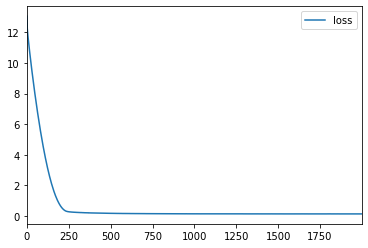

In [15]:
DataFrame(m_fti.history).plot()
plt.grid = True
plt.show

In [16]:
X_val.shape

(436, 83)

In [17]:
pred = model.predict(X_val)
pred = y_scale.inverse_transform(pred)

In [18]:
RMSE = np.sqrt(MSE(pred,y_val))
print(RMSE.round(4))

22175.2687


In [19]:
pred_kagg = model.predict(df_Kagg)

In [20]:
pred_kagg.shape

(1459, 1)

In [21]:
pred_kagg = y_scale.inverse_transform(pred_kagg)

In [22]:
pred_kagg


array([[124001.805],
       [156025.75 ],
       [170401.78 ],
       ...,
       [165634.64 ],
       [116251.41 ],
       [221635.36 ]], dtype=float32)

In [23]:
submission["SalePrice"]= pred_kagg
submission.to_csv("new_kagg10.csv", index= False)

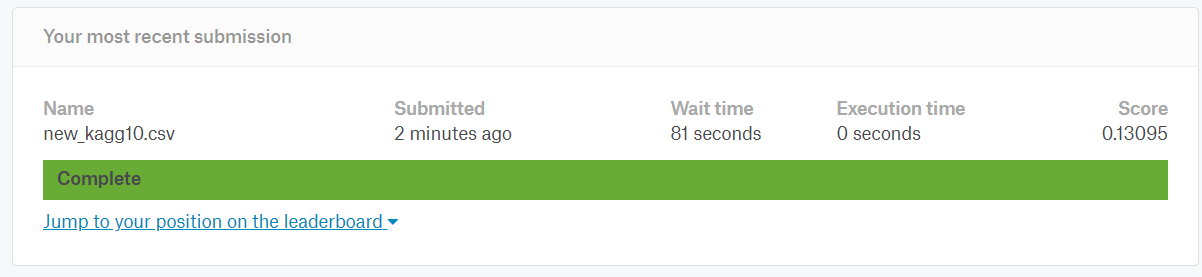

In [24]:
from IPython.display import Image
Image('png/Neuro.png')